In [1]:
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("creditcard.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
# Count of fraudulent vs non-fraudulent transactions
print(df['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


In [7]:
fraud_percentage = (df['Class'].value_counts(normalize=True) * 100)
print(fraud_percentage)

Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


In [8]:
# Descriptive statistics
print(df.describe())


                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

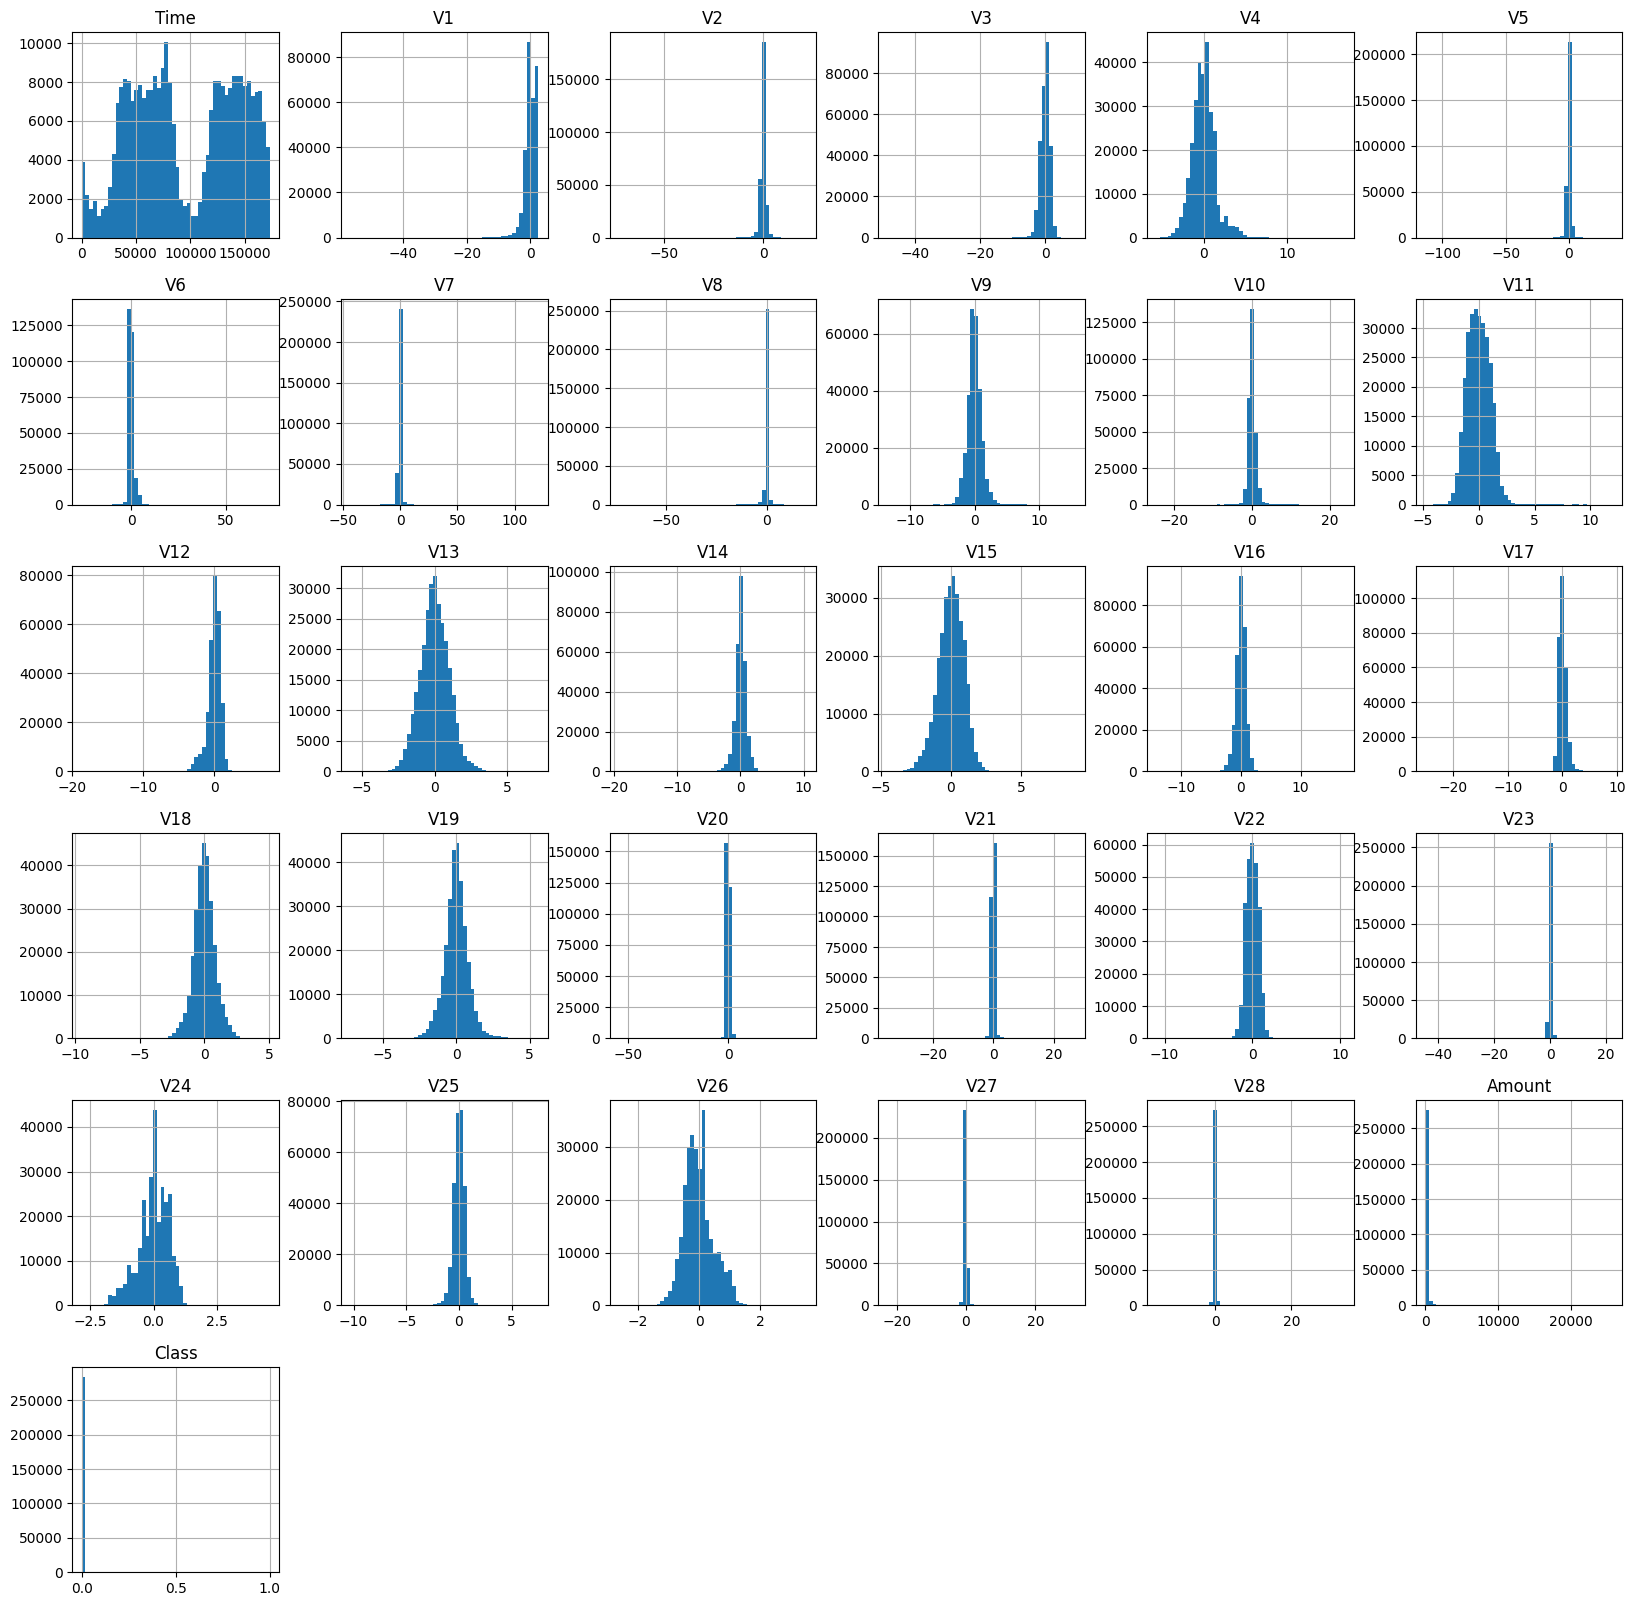

In [9]:
# Plot histograms for all features
df.hist(figsize=(20, 20), bins=50)
plt.show()


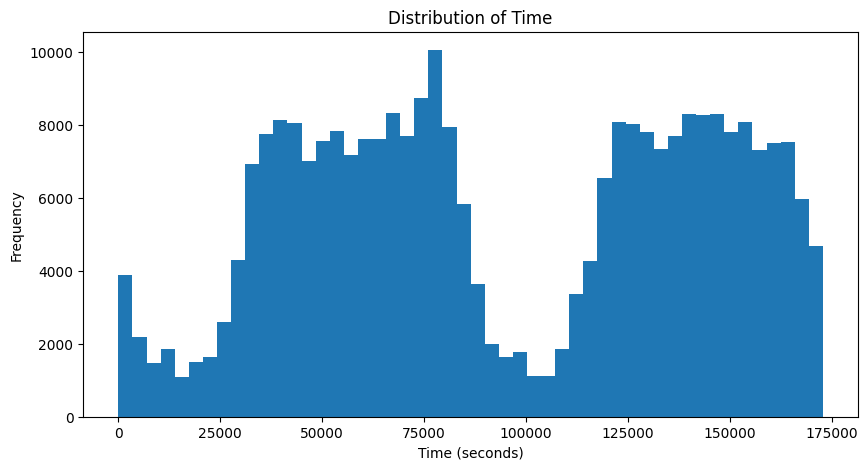

In [10]:
# Plot distribution of 'Time'
plt.figure(figsize=(10, 5))
plt.hist(df['Time'], bins=50)
plt.title('Distribution of Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.show()




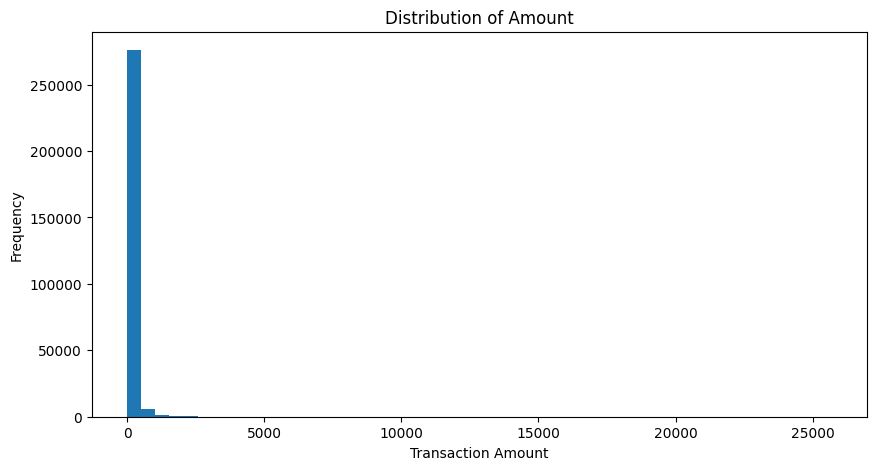

In [11]:
# Plot distribution of 'Amount'
plt.figure(figsize=(10, 5))
plt.hist(df['Amount'], bins=50)
plt.title('Distribution of Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

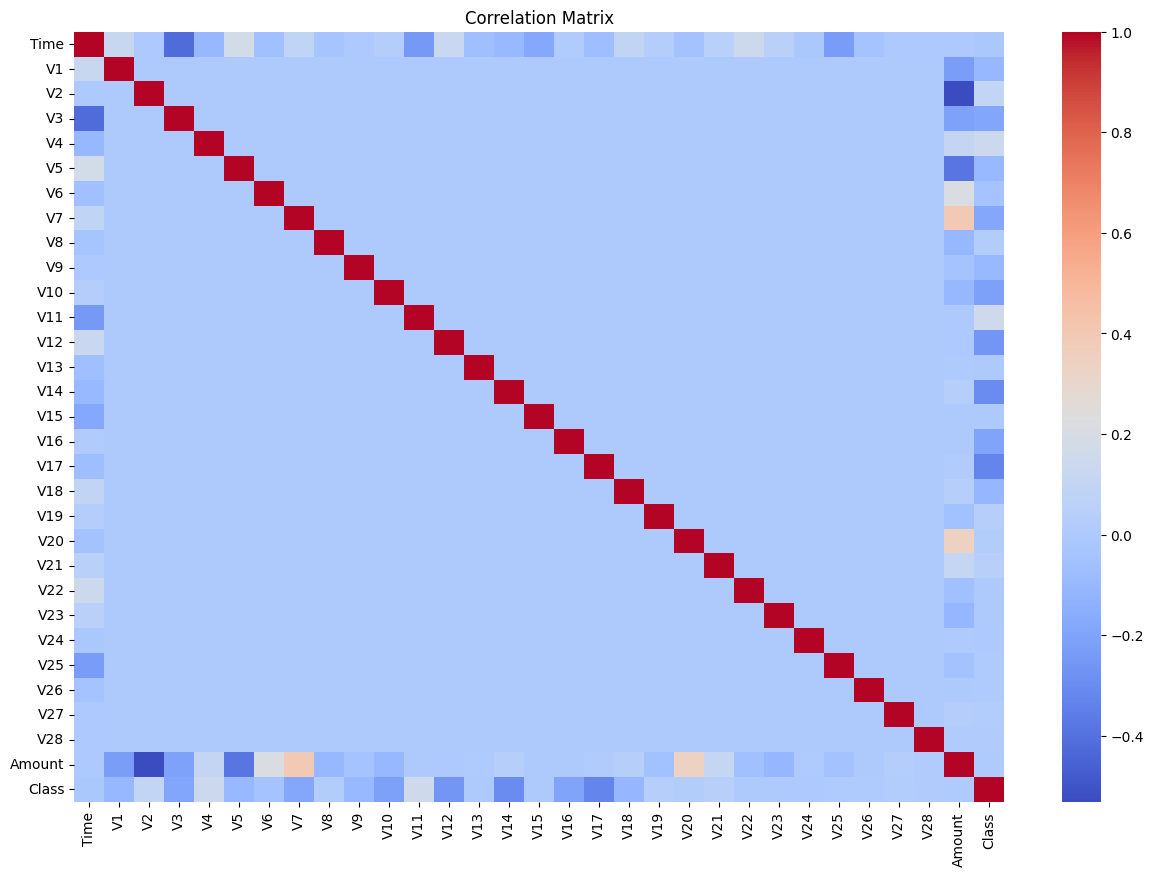

In [12]:
# Compute correlation matrix
corr_matrix = df.corr()

# Visualize correlations using a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

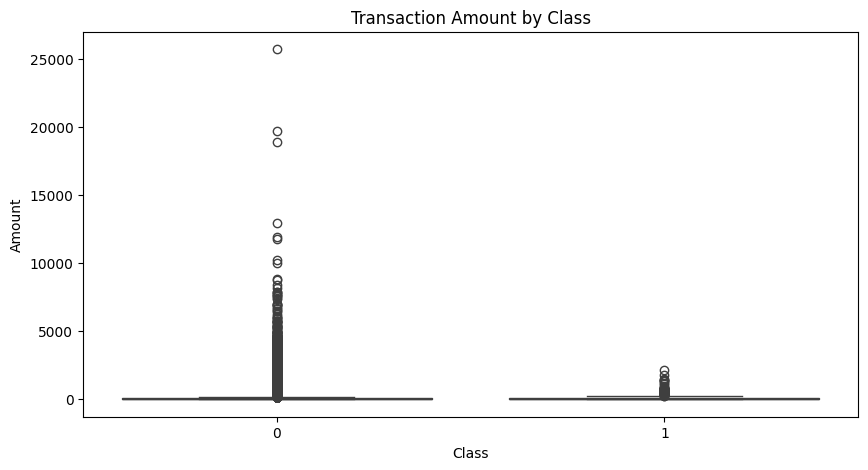

In [13]:
# Separate the data classes
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0]

# Compare Amount for Fraud and Non-Fraud
plt.figure(figsize=(10, 5))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Transaction Amount by Class')
plt.show()

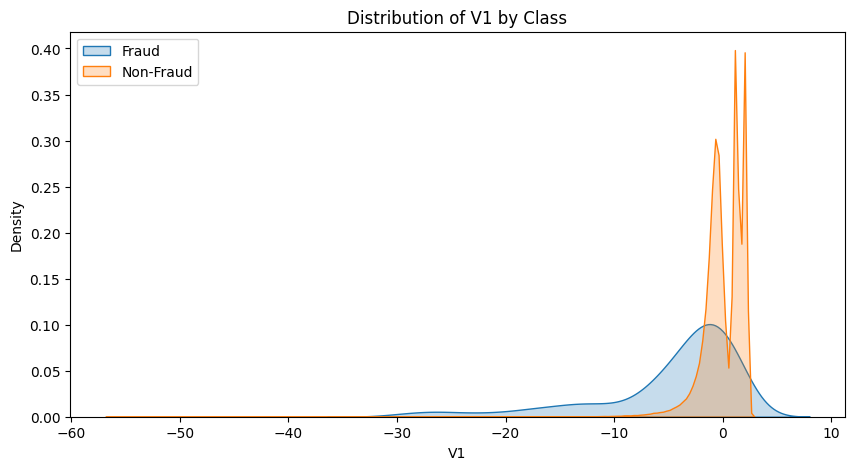

In [14]:
#Compare distributions of V1 for Fraud and Non-Fraud
plt.figure(figsize=(10, 5))
sns.kdeplot(fraud['V1'], label='Fraud', fill=True)
sns.kdeplot(non_fraud['V1'], label='Non-Fraud', fill=True)
plt.title('Distribution of V1 by Class')
plt.legend()
plt.show()


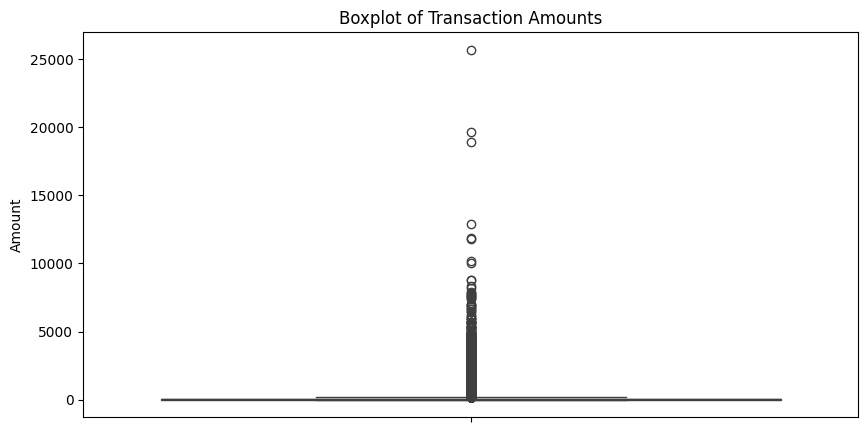

In [15]:
# Boxplot for Amount to check for outliers
plt.figure(figsize=(10, 5))
sns.boxplot(df['Amount'])
plt.title('Boxplot of Transaction Amounts')
plt.show()


In [16]:
df['Amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))
time = df['Time']
df['Time'] = (time - time.min()) / (time.max() - time.min())
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,0
2,0.000006,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,0
3,0.000006,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,0
4,0.000012,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,0.999965,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.296653,0
284803,0.999971,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0.038986,0
284804,0.999977,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0.641096,0
284805,0.999977,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.167680,0


In [17]:
# First, separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

In [18]:
# First split: separate test set (20% of data)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: separate validation set from remaining data (25% of temp data = 20% of original data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, test_size=0.25, random_state=42, stratify=y_train_temp
)

In [19]:
# Print shapes to verify
print("Dataset shapes:")
print(f"Full dataset: {X.shape}")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Dataset shapes:
Full dataset: (284807, 30)
Training set: (170883, 30)
Validation set: (56962, 30)
Test set: (56962, 30)


In [20]:
len(X_train), len(X_val), len(X_test)

(170883, 56962, 56962)

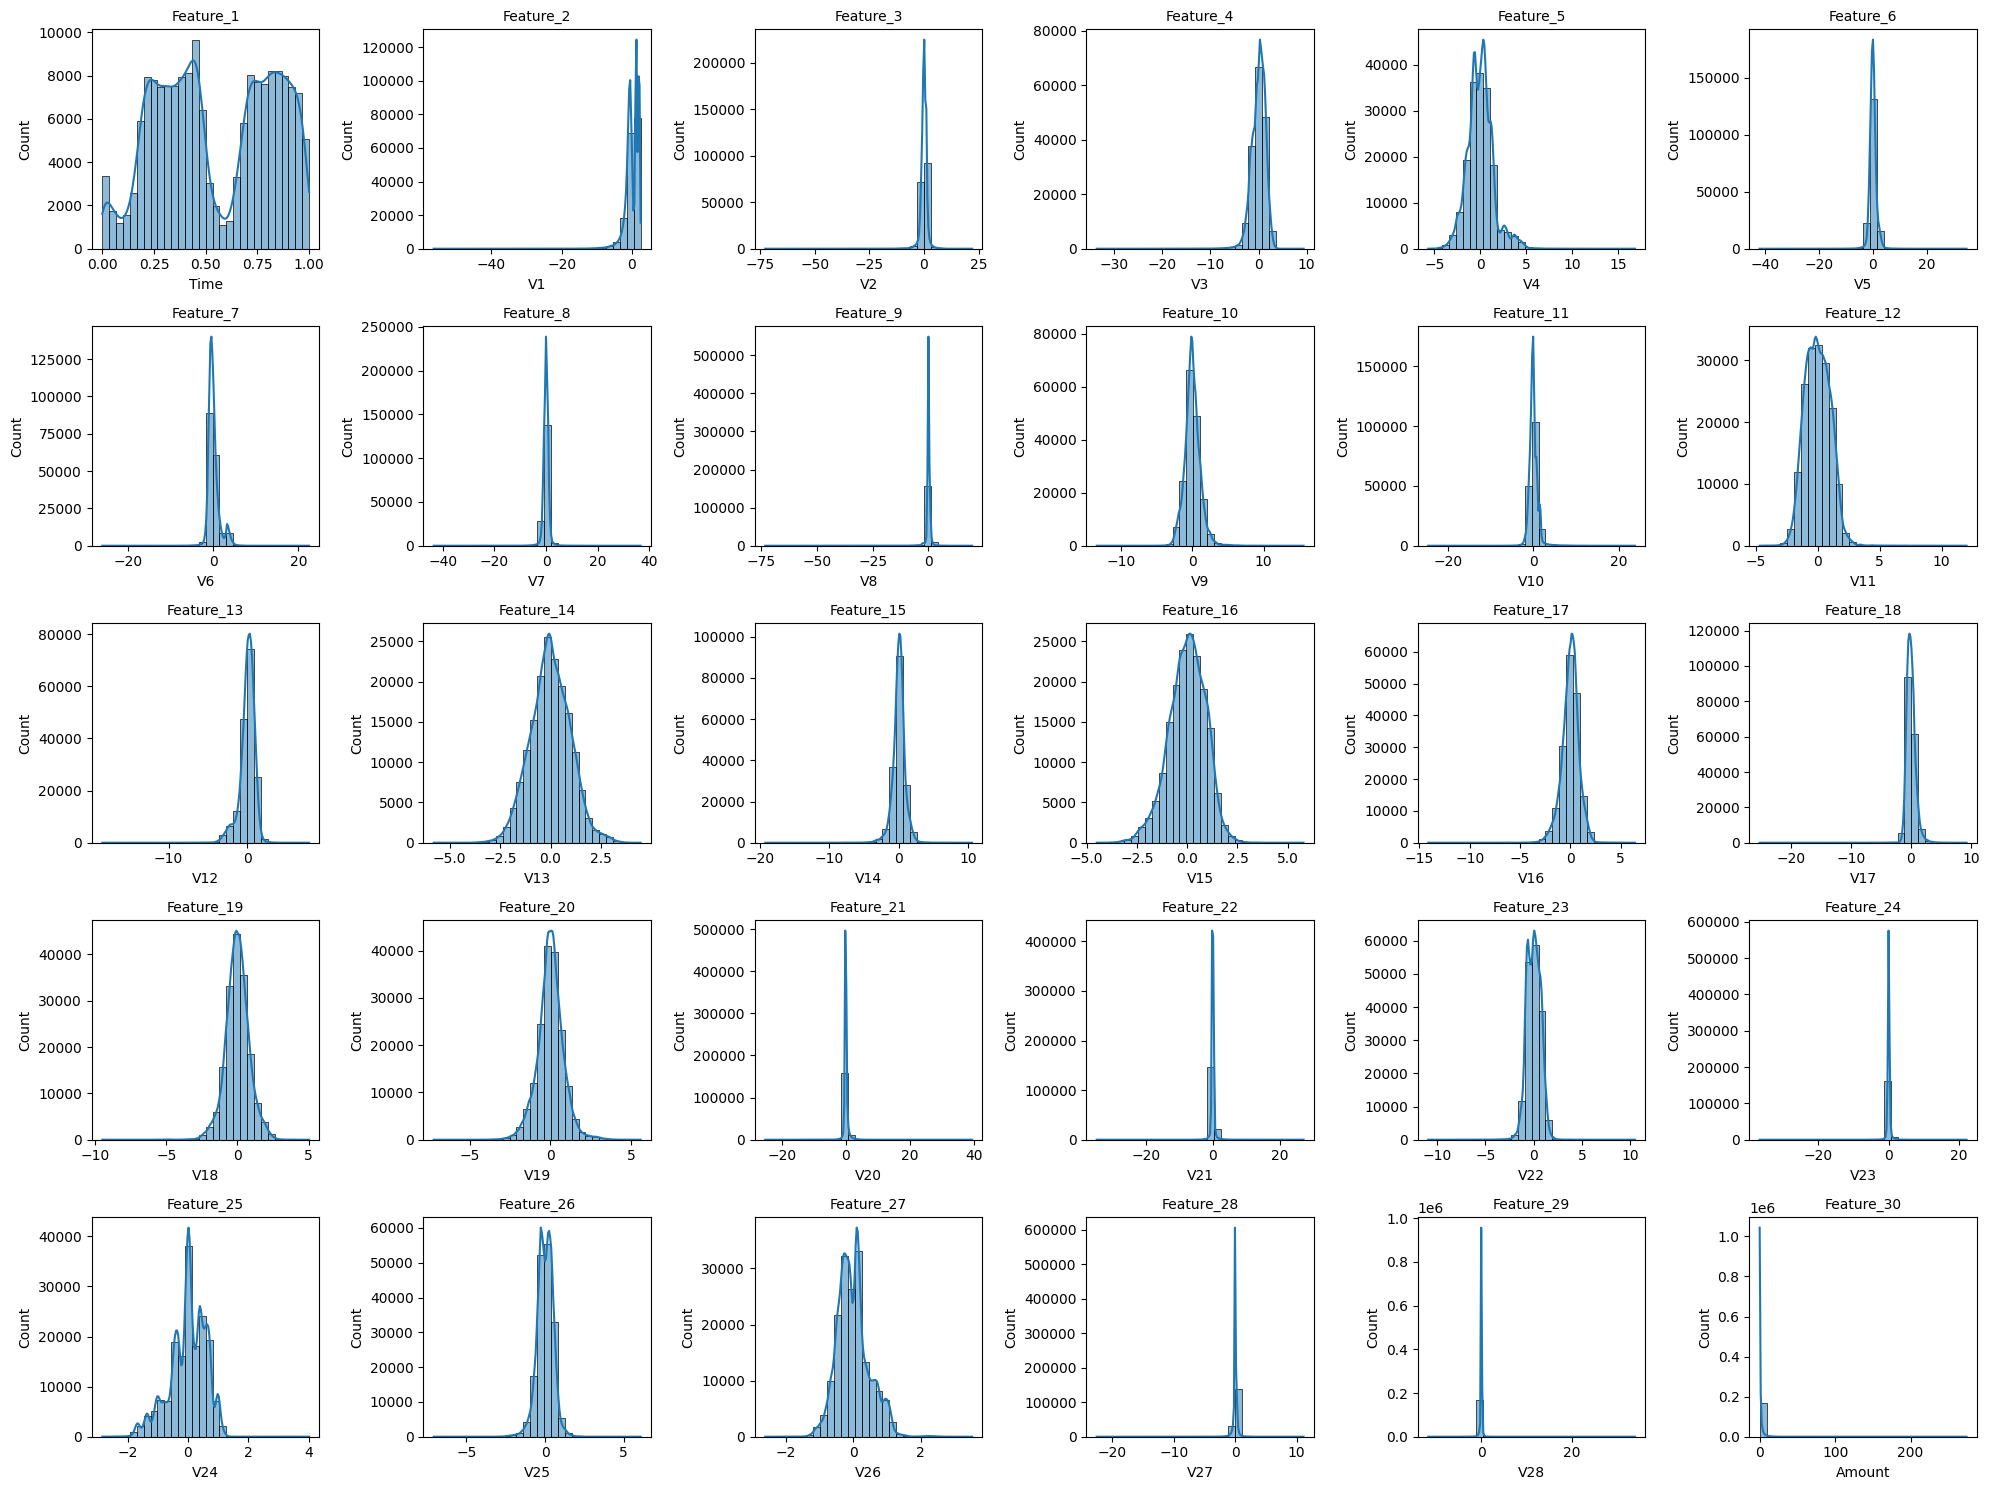

In [21]:
plt.figure(figsize=(20, 15))
n = 1

# Loop through the columns of the DataFrame
for i in range(X_train.shape[1]):  
    plt.subplot(5, 6, n)  # Create a grid of subplots
    sns.histplot(data=X_train.iloc[:, i], kde=True, bins=30)  # Use .iloc for column access
    plt.title(f'Feature_{i+1}', fontsize=10)  # Add feature title
    n += 1

plt.tight_layout()
plt.show()

# Prevent future warning limits on open figures
plt.rcParams.update({'figure.max_open_warning': 0})


In [22]:
# Apply PowerTransformer to the entire NumPy array
pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=False)
X_train = pt.fit_transform(X_train)
X_test = pt.transform(X_test)


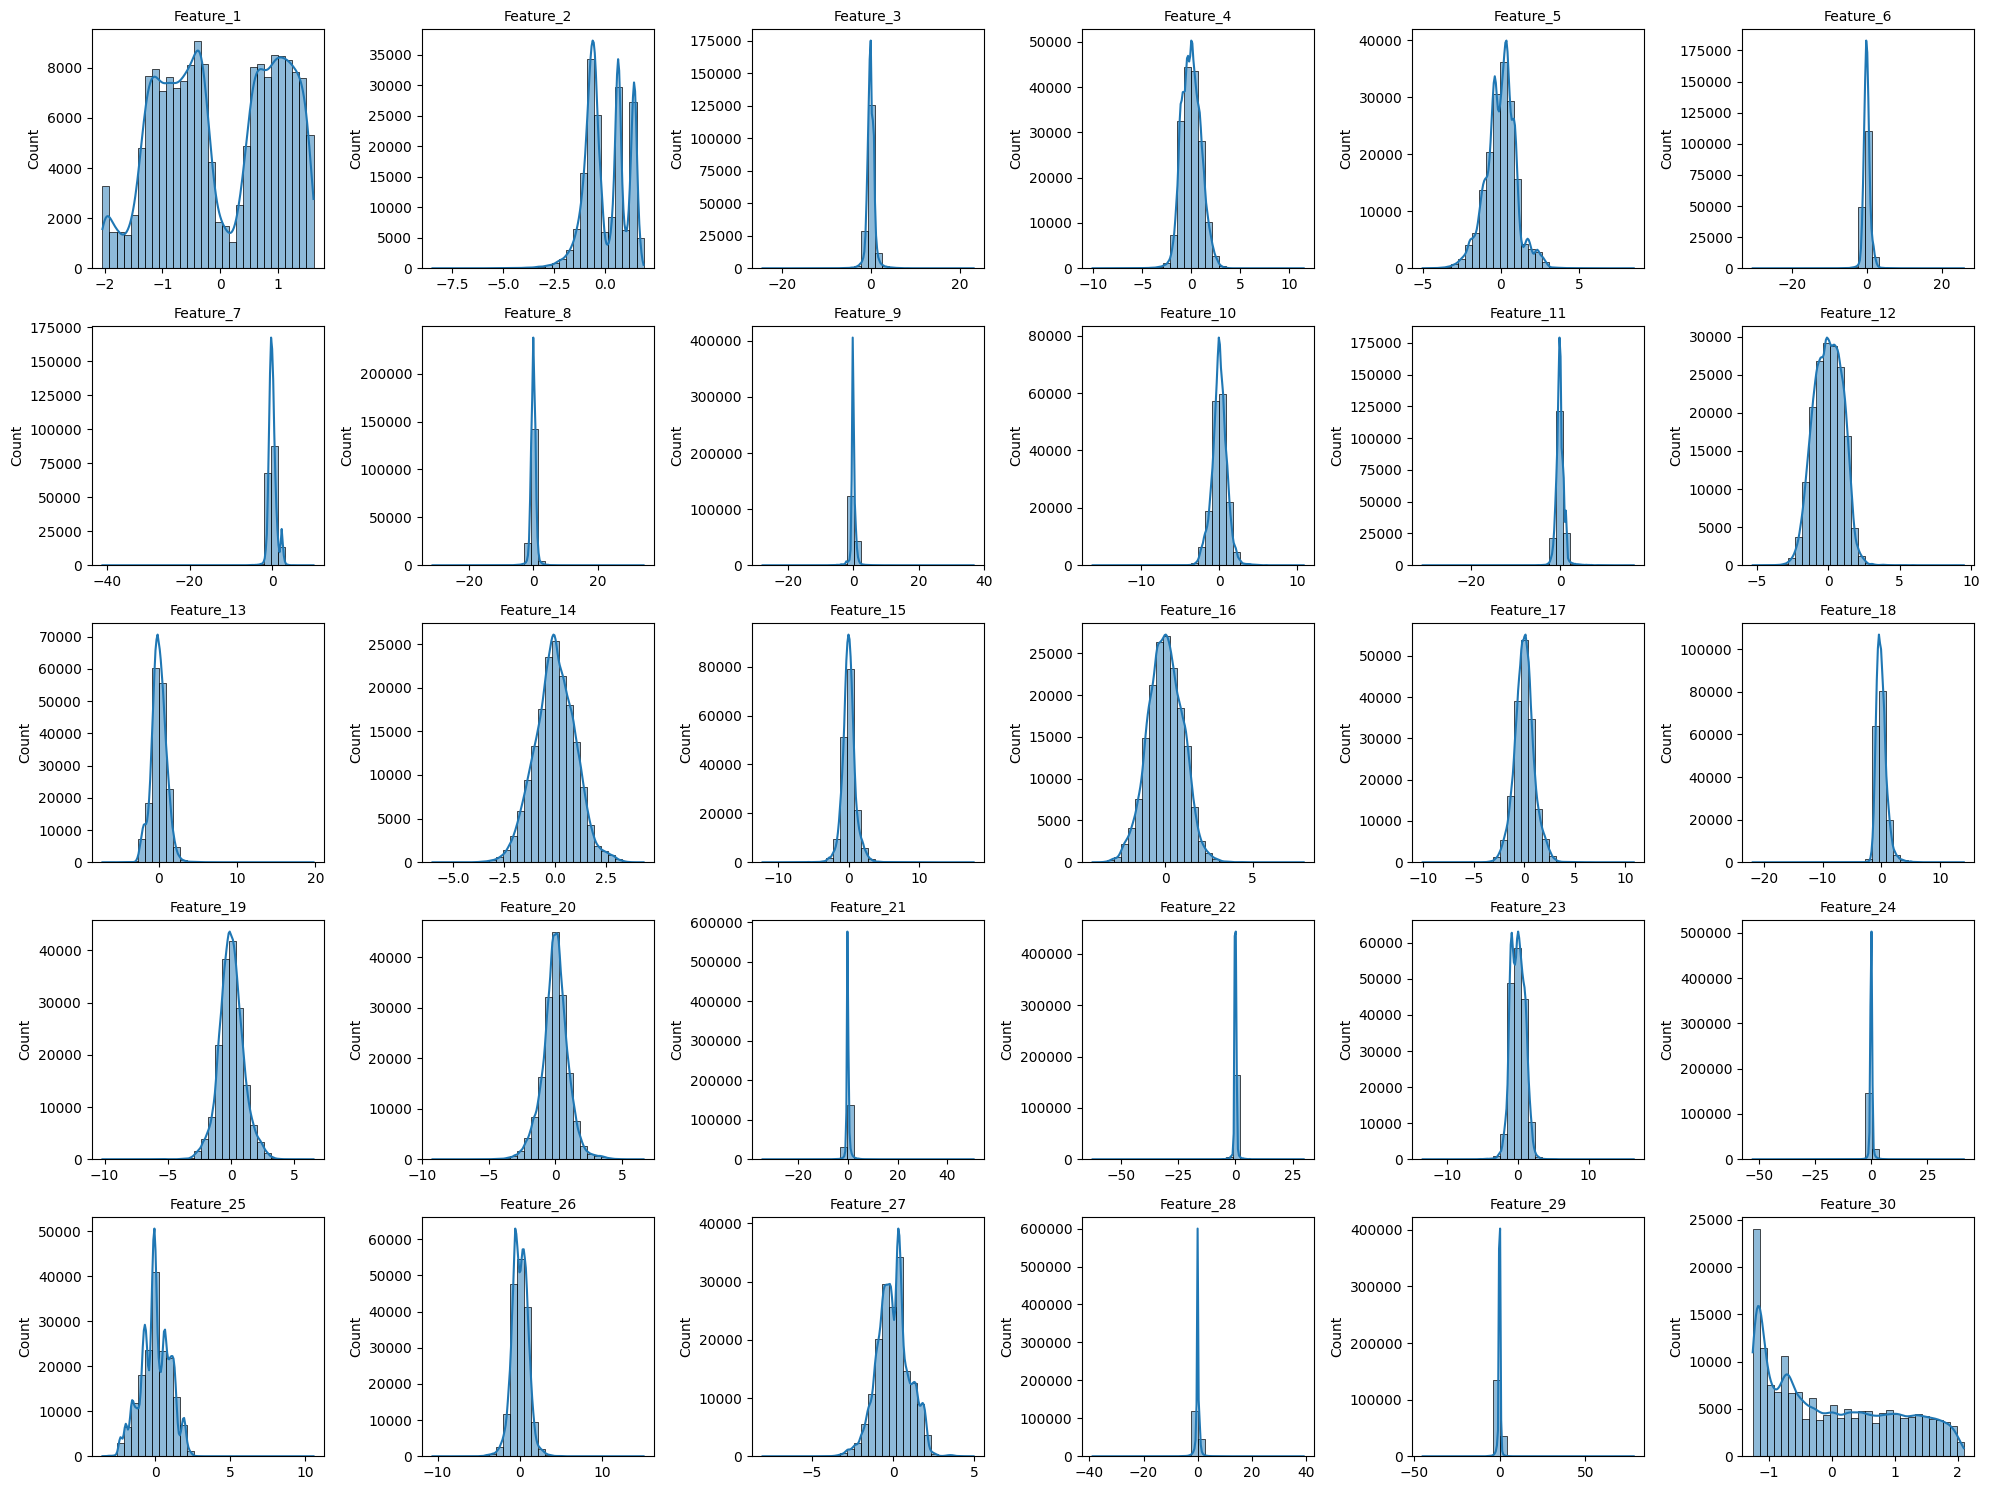

In [23]:
plt.figure(figsize=(20,15))
n = 1

for i in range(X_train.shape[1]):  # Iterate through columns
    plt.subplot(5, 6, n)
    sns.histplot(data=X_train[:, i], kde=True, bins=30)  # Access the i-th column
    plt.title(f'Feature_{i+1}', fontsize=10)  # Title with generic names
    n += 1

plt.tight_layout()
plt.show()
plt.rcParams.update({'figure.max_open_warning': 0})


In [24]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train.astype('float'), y_train)
print("Before performing smote : ", Counter(y_train))
print("After performing smote : ", Counter(y_train_smote))

Before performing smote :  Counter({0: 170588, 1: 295})
After performing smote :  Counter({0: 170588, 1: 170588})


In [25]:
LR_model = LogisticRegression(max_iter=1000)
LR_model.fit(X_train, y_train)
print("Training accuracy: ", LR_model.score(X_train, y_train))

Training accuracy:  0.9993621366666081


In [26]:
print(classification_report(y_val, LR_model.predict(X_val), target_names=['Non-Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56863
       Fraud       0.51      0.76      0.61        99

    accuracy                           1.00     56962
   macro avg       0.76      0.88      0.81     56962
weighted avg       1.00      1.00      1.00     56962



In [27]:
# Train Logistic Regression on SMOTE data
LR_model_smote = LogisticRegression(max_iter=1000)
LR_model_smote.fit(X_train_smote, y_train_smote)
print("\nLogistic Regression with SMOTE:")
print("Training accuracy: ", LR_model_smote.score(X_train_smote, y_train_smote))


Logistic Regression with SMOTE:
Training accuracy:  0.959959082702183


In [28]:

print("\nValidation Results:")
print(classification_report(y_val, LR_model_smote.predict(X_val), target_names=['Non-Fraud', 'Fraud']))


Validation Results:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.95      0.98     56863
       Fraud       0.03      0.91      0.06        99

    accuracy                           0.95     56962
   macro avg       0.52      0.93      0.52     56962
weighted avg       1.00      0.95      0.97     56962



In [29]:
shallow_nn = Sequential()
shallow_nn.add(InputLayer((X_train.shape[1],)))
shallow_nn.add(Dense(2, activation='relu'))
shallow_nn.add(BatchNormalization())
shallow_nn.add(Dense(1, activation='sigmoid'))

checkpoint = ModelCheckpoint('shallow_nn.keras', save_best_only=True)
shallow_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
shallow_nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │            62 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2)              │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73 (292.00 B)

 Trainable params: 69 (276.00 B)

 Non-trainable params: 4 (16.00 B)

In [31]:
shallow_nn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=checkpoint)

Epoch 1/5
5341/5341 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9380 - loss: 0.2123 - val_accuracy: 0.9990 - val_loss: 0.0103
Epoch 2/5
5341/5341 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9986 - val_loss: 0.0124
Epoch 3/5
5341/5341 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9970 - val_loss: 0.0233
Epoch 4/5
5341/5341 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9975 - val_loss: 0.0181
Epoch 5/5
5341/5341 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.9963 - val_loss: 0.0273


In [32]:
def neural_net_predictions(model, x):
  return (model.predict(x).flatten() > 0.5).astype(int)
neural_net_predictions(shallow_nn, X_val)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


array([0, 0, 0, ..., 0, 0, 0])

In [33]:
print(classification_report(y_val, neural_net_predictions(shallow_nn, X_val), target_names=['Not Fraud', 'Fraud']))

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56863
       Fraud       0.29      0.81      0.43        99

    accuracy                           1.00     56962
   macro avg       0.65      0.90      0.71     56962
weighted avg       1.00      1.00      1.00     56962



In [34]:
# Train Neural Network on SMOTE data
shallow_nn_smote = Sequential()
shallow_nn_smote.add(InputLayer((X_train_smote.shape[1],)))
shallow_nn_smote.add(Dense(2, activation='relu'))
shallow_nn_smote.add(BatchNormalization())
shallow_nn_smote.add(Dense(1, activation='sigmoid'))

checkpoint_smote = ModelCheckpoint('shallow_nn_smote.keras', save_best_only=True)
shallow_nn_smote.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
shallow_nn_smote.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 2)              │            62 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2)              │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73 (292.00 B)

 Trainable params: 69 (276.00 B)

 Non-trainable params: 4 (16.00 B)

In [36]:
# Train the neural network
shallow_nn_smote.fit(X_train_smote, y_train_smote, 
                    validation_data=(X_val, y_val), 
                    epochs=5, 
                    callbacks=checkpoint_smote)

Epoch 1/5
10662/10662 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.9164 - loss: 0.2130 - val_accuracy: 0.9573 - val_loss: 0.0968
Epoch 2/5
10662/10662 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.9572 - loss: 0.1061 - val_accuracy: 0.9747 - val_loss: 0.0793
Epoch 3/5
10662/10662 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.9620 - loss: 0.0972 - val_accuracy: 0.9803 - val_loss: 0.0661
Epoch 4/5
10662/10662 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.9639 - loss: 0.0921 - val_accuracy: 0.9799 - val_loss: 0.0673
Epoch 5/5
10662/10662 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.9645 - loss: 0.0915 - val_accuracy: 0.9807 - val_loss: 0.0656


In [37]:
print("\nNeural Network with SMOTE - Validation Results:")
print(classification_report(y_val, 
                          neural_net_predictions(shallow_nn_smote, X_val), 
                          target_names=['Not Fraud', 'Fraud']))


Neural Network with SMOTE - Validation Results:
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99     56863
       Fraud       0.07      0.88      0.14        99

    accuracy                           0.98     56962
   macro avg       0.54      0.93      0.56     56962
weighted avg       1.00      0.98      0.99     56962



In [38]:
rf = RandomForestClassifier(max_depth=2, n_jobs=-1)
rf.fit(X_train, y_train)
print(classification_report(y_val, rf.predict(X_val), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56863
       Fraud       0.85      0.58      0.69        99

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962



In [39]:
# Train Random Forest on SMOTE data
rf_smote = RandomForestClassifier(max_depth=2, n_jobs=-1)
rf_smote.fit(X_train_smote, y_train_smote)
print("\nRandom Forest with SMOTE - Validation Results:")
print(classification_report(y_val, rf_smote.predict(X_val), 
                          target_names=['Not Fraud', 'Fraud']))


Random Forest with SMOTE - Validation Results:
              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      1.00     56863
       Fraud       0.21      0.81      0.33        99

    accuracy                           0.99     56962
   macro avg       0.60      0.90      0.66     56962
weighted avg       1.00      0.99      1.00     56962



In [40]:
gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1, random_state=0)
gbc.fit(X_train, y_train)
print(classification_report(y_val, gbc.predict(X_val), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56863
       Fraud       0.76      0.53      0.62        99

    accuracy                           1.00     56962
   macro avg       0.88      0.76      0.81     56962
weighted avg       1.00      1.00      1.00     56962



In [41]:
# Train Gradient Boosting on SMOTE data
gbc_smote = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, 
                                      max_depth=1, random_state=0)
gbc_smote.fit(X_train_smote, y_train_smote)
print("\nGradient Boosting with SMOTE - Validation Results:")
print(classification_report(y_val, gbc_smote.predict(X_val), 
                          target_names=['Not Fraud', 'Fraud']))


Gradient Boosting with SMOTE - Validation Results:
              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99     56863
       Fraud       0.06      0.86      0.12        99

    accuracy                           0.98     56962
   macro avg       0.53      0.92      0.55     56962
weighted avg       1.00      0.98      0.99     56962



In [42]:
svc = LinearSVC(class_weight='balanced', random_state=42)
svc.fit(X_train, y_train)
print(classification_report(y_val, svc.predict(X_val), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      0.96      0.98     56863
       Fraud       0.04      0.90      0.07        99

    accuracy                           0.96     56962
   macro avg       0.52      0.93      0.53     56962
weighted avg       1.00      0.96      0.98     56962



In [43]:
# Train SVC on SMOTE data
svc_smote = LinearSVC(class_weight='balanced', random_state=42)
svc_smote.fit(X_train_smote, y_train_smote)
print("\nLinear SVC with SMOTE - Validation Results:")
print(classification_report(y_val, svc_smote.predict(X_val), 
                          target_names=['Not Fraud', 'Fraud']))


Linear SVC with SMOTE - Validation Results:
              precision    recall  f1-score   support

   Not Fraud       1.00      0.97      0.98     56863
       Fraud       0.04      0.89      0.08        99

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.53     56962
weighted avg       1.00      0.97      0.98     56962



In [44]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [45]:
# Create confusion matrices for original models
print("Confusion Matrices for Original Models:")

Confusion Matrices for Original Models:



Logistic Regression:


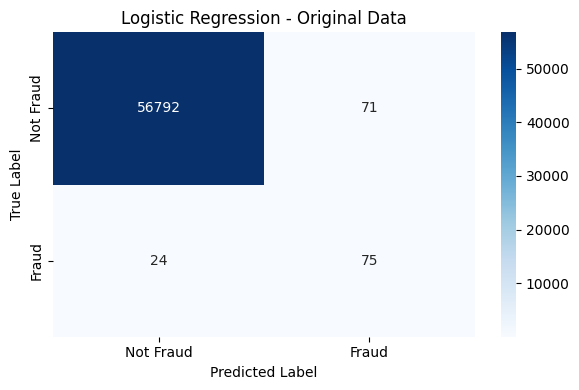

In [46]:
print("\nLogistic Regression:")
plot_confusion_matrix(y_val, LR_model.predict(X_val), 
                     'Logistic Regression - Original Data')


Neural Network:
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


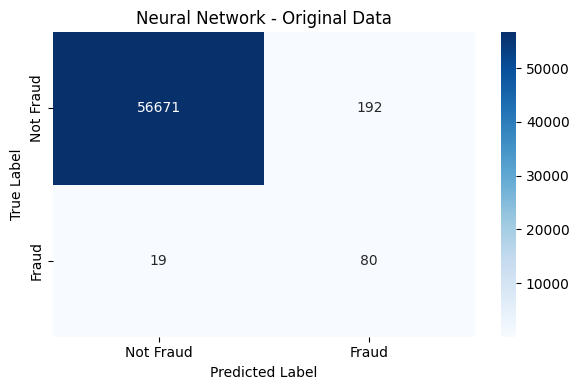

In [47]:
print("\nNeural Network:")
plot_confusion_matrix(y_val, neural_net_predictions(shallow_nn, X_val),
                     'Neural Network - Original Data')


Random Forest:


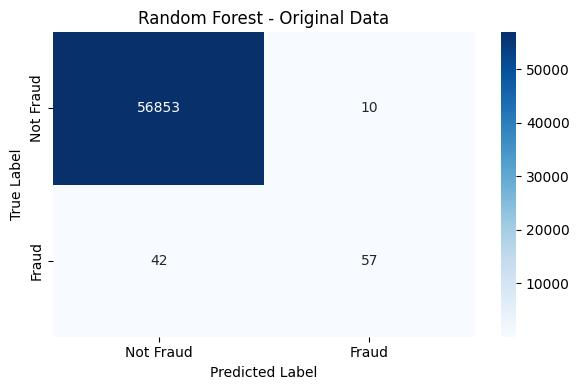

In [48]:
print("\nRandom Forest:")
plot_confusion_matrix(y_val, rf.predict(X_val),
                     'Random Forest - Original Data')


Gradient Boosting:


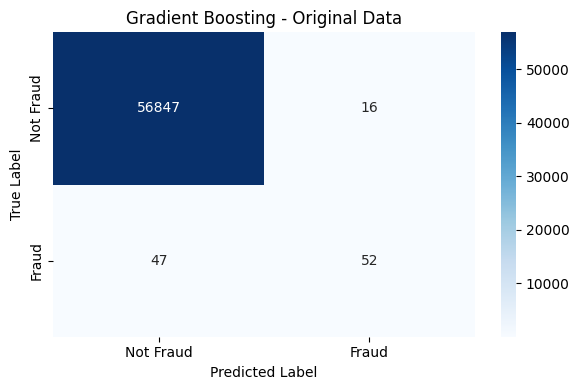

In [49]:
print("\nGradient Boosting:")
plot_confusion_matrix(y_val, gbc.predict(X_val),
                     'Gradient Boosting - Original Data')


Linear SVC:


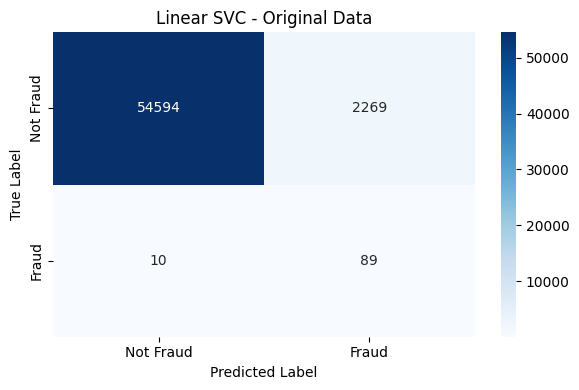

In [50]:
print("\nLinear SVC:")
plot_confusion_matrix(y_val, svc.predict(X_val),
                     'Linear SVC - Original Data')

In [51]:
# Create confusion matrices for SMOTE models
print("\nConfusion Matrices for SMOTE Models:")


Confusion Matrices for SMOTE Models:



Logistic Regression with SMOTE:


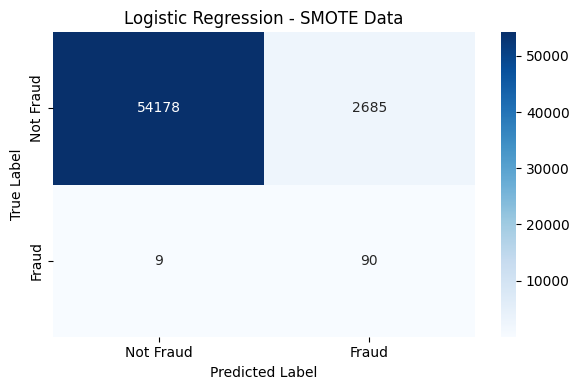

In [52]:
print("\nLogistic Regression with SMOTE:")
plot_confusion_matrix(y_val, LR_model_smote.predict(X_val),
                     'Logistic Regression - SMOTE Data')

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


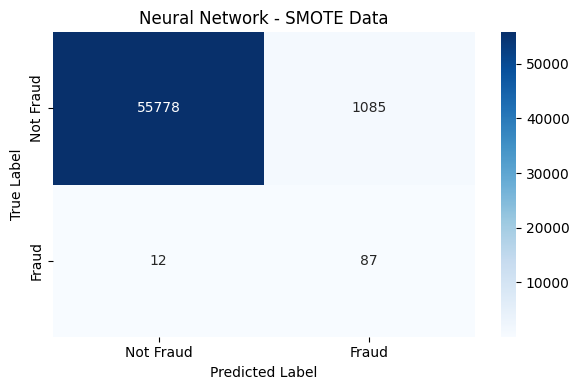

In [53]:
("\nNeural Network with SMOTE:")
plot_confusion_matrix(y_val, neural_net_predictions(shallow_nn_smote, X_val),
                     'Neural Network - SMOTE Data')


Random Forest with SMOTE:


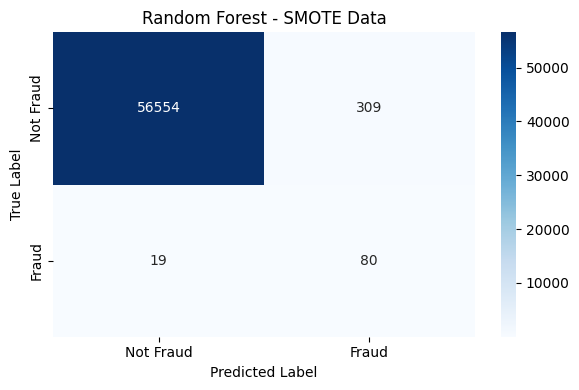

In [54]:
print("\nRandom Forest with SMOTE:")
plot_confusion_matrix(y_val, rf_smote.predict(X_val),
                     'Random Forest - SMOTE Data')


Gradient Boosting with SMOTE:


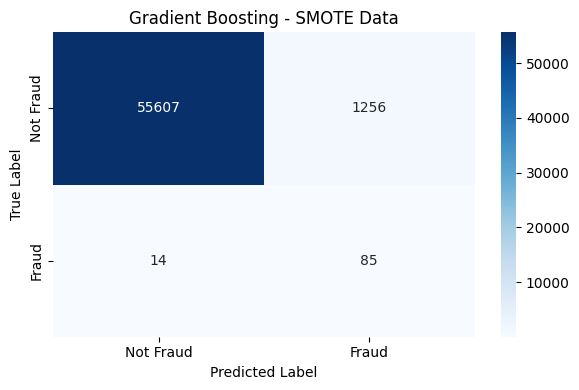

In [55]:
print("\nGradient Boosting with SMOTE:")
plot_confusion_matrix(y_val, gbc_smote.predict(X_val),
                     'Gradient Boosting - SMOTE Data')


Linear SVC with SMOTE:


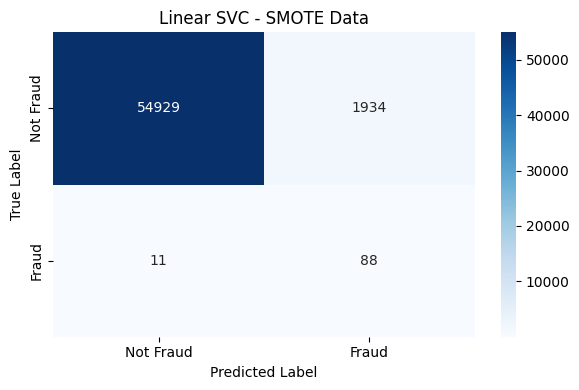

In [56]:
print("\nLinear SVC with SMOTE:")
plot_confusion_matrix(y_val, svc_smote.predict(X_val),
                     'Linear SVC - SMOTE Data')

In [57]:
# Create a summary DataFrame for visualization
def get_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1

# Helper function for neural network predictions
def get_nn_predictions(model, X):
    predictions = model.predict(X)
    return (predictions > 0.5).astype(int).flatten()

# Create list of model predictions
models_data = [
    ('Logistic Regression', 'Original', LR_model.predict(X_val)),
    ('Neural Network', 'Original', get_nn_predictions(shallow_nn, X_val)),
    ('Random Forest', 'Original', rf.predict(X_val)),
    ('Gradient Boosting', 'Original', gbc.predict(X_val)),
    ('Linear SVC', 'Original', svc.predict(X_val)),
    ('Logistic Regression', 'SMOTE', LR_model_smote.predict(X_val)),
    ('Neural Network', 'SMOTE', get_nn_predictions(shallow_nn_smote, X_val)),
    ('Random Forest', 'SMOTE', rf_smote.predict(X_val)),
    ('Gradient Boosting', 'SMOTE', gbc_smote.predict(X_val)),
    ('Linear SVC', 'SMOTE', svc_smote.predict(X_val))
]

# Initialize summary DataFrame
models_summary = pd.DataFrame(columns=['Model', 'Data', 'Accuracy', 'Precision', 'Recall', 'F1'])


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [58]:
# Collect metrics for each model
for model_name, data_type, predictions in models_data:
    accuracy, precision, recall, f1 = get_metrics(y_val, predictions)
    new_row = pd.DataFrame([{
        'Model': model_name,
        'Data': data_type,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    }])
    models_summary = pd.concat([models_summary, new_row], ignore_index=True)

# Display the summary table
print("\nModel Performance Summary:")
print(models_summary.round(4))


Model Performance Summary:
                 Model      Data  Accuracy  Precision  Recall      F1
0  Logistic Regression  Original    0.9983     0.5137  0.7576  0.6122
1       Neural Network  Original    0.9963     0.2941  0.8081  0.4313
2        Random Forest  Original    0.9991     0.8507  0.5758  0.6867
3    Gradient Boosting  Original    0.9989     0.7647  0.5253  0.6228
4           Linear SVC  Original    0.9600     0.0377  0.8990  0.0724
5  Logistic Regression     SMOTE    0.9527     0.0324  0.9091  0.0626
6       Neural Network     SMOTE    0.9807     0.0742  0.8788  0.1369
7        Random Forest     SMOTE    0.9942     0.2057  0.8081  0.3279
8    Gradient Boosting     SMOTE    0.9777     0.0634  0.8586  0.1181
9           Linear SVC     SMOTE    0.9659     0.0435  0.8889  0.0830


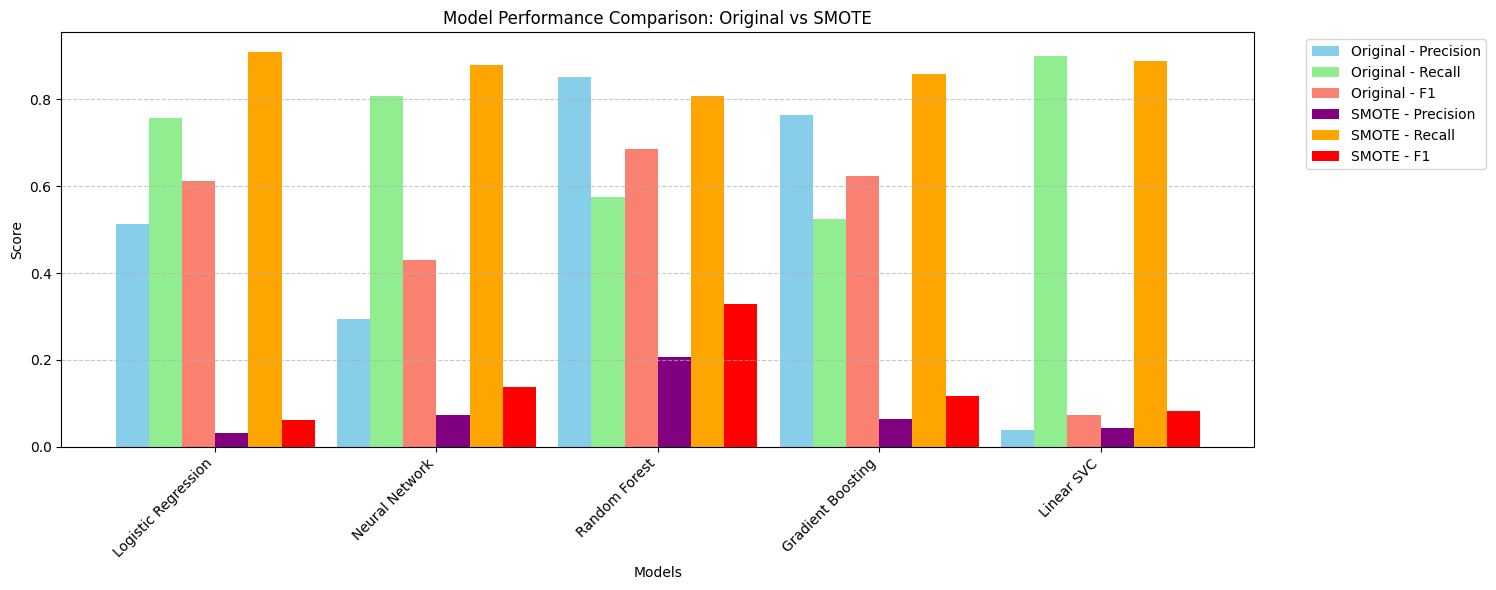

In [61]:
# Create visualization
plt.figure(figsize=(15, 6))

# Set width of bars and positions of the bars
barWidth = 0.15
r1 = np.arange(len(models_summary['Model'].unique()))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

# Create bars
original_data = models_summary[models_summary['Data'] == 'Original']
smote_data = models_summary[models_summary['Data'] == 'SMOTE']

# Original data bars
plt.bar(r1, original_data['Precision'], width=barWidth, label='Original - Precision', color='skyblue')
plt.bar(r2, original_data['Recall'], width=barWidth, label='Original - Recall', color='lightgreen')
plt.bar(r3, original_data['F1'], width=barWidth, label='Original - F1', color='salmon')

# SMOTE data bars
plt.bar(r4, smote_data['Precision'], width=barWidth, label='SMOTE - Precision', color='purple')
plt.bar(r5, smote_data['Recall'], width=barWidth, label='SMOTE - Recall', color='orange')
plt.bar(r6, smote_data['F1'], width=barWidth, label='SMOTE - F1', color='red')

# Add labels
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison: Original vs SMOTE')
plt.xticks([r + barWidth*2.5 for r in range(len(r1))], 
           original_data['Model'], rotation=45, ha='right')

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Add grid
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()